In [ ]:

import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout,Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from google.colab import drive




In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
train_path = "/content/drive/MyDrive/animals/train"
val_path = "/content/drive/MyDrive/animals/val"

preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)

num_species_classes = len(train_dataset.classes)
print("Number of species classes:", num_species_classes)

Number of species classes: 19


['bear', 'bison', 'boar', 'cow', 'deer', 'donkey', 'elephant', 'fox', 'goat', 'hippopotamus', 'horse', 'hyena', 'leopard', 'lion', 'ox', 'pig', 'porcupine', 'rhinoceros', 'tiger']


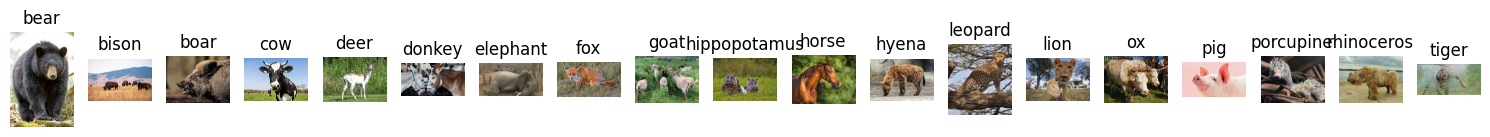

In [ ]:
species_list = sorted(os.listdir(train_path))
print(species_list)
fig, axes = plt.subplots(1, len(species_list), figsize=(15, 5))
for i, species in enumerate(species_list):
    species_path = os.path.join(train_path, species)

    image_files = [f for f in os.listdir(species_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    if image_files:
        img_path = os.path.join(species_path, image_files[0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(species)

plt.tight_layout()
plt.show()


In [ ]:
from torch.utils.data import WeightedRandomSampler

In [ ]:
class_counts = [len([img for img, label in train_dataset.samples if label == i]) for i in range(num_species_classes)]
max_count = max(class_counts)
weights = [max_count / class_counts[label] for _, label in train_dataset.samples]
sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Define species danger levels
low_danger_species = {"bison", "deer", "donkey", "cow", "horse", "pig", "goat", "porcupine"}
medium_danger_species = {"boar", "elephant", "ox", "hippopotamus", "rhinoceros"}
high_danger_species = {"bear", "fox", "hyena", "leopard", "lion", "tiger"}

# Map species to danger levels
species_to_label = {
    species: (2 if species in high_danger_species else
              1 if species in medium_danger_species else
              0) for species in train_dataset.classes
}

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNNTransformer(nn.Module):
    def __init__(self, num_species_classes, num_danger_levels=3):
        super(CNNTransformer, self).__init__()

        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()

        for param in self.cnn.parameters():
            param.requires_grad = False

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=512, nhead=8), num_layers=3
        )

        self.fc_species = nn.Linear(512, num_species_classes)  # Species classification
        self.fc_danger = nn.Linear(512, num_danger_levels)  # Danger classification

    def forward(self, x):
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.unsqueeze(1)

        transformer_output = self.transformer(cnn_features)
        transformer_output = transformer_output.squeeze(1)

        species_output = self.fc_species(transformer_output)  # Predict species
        danger_output = self.fc_danger(transformer_output)  # Predict danger level

        return species_output, danger_output


In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, species_weight=1.0, danger_weight=1.0):
        super(CombinedLoss, self).__init__()
        self.species_loss = nn.CrossEntropyLoss()  # For species classification
        self.danger_loss = nn.CrossEntropyLoss()  # For danger level classification
        self.species_weight = species_weight
        self.danger_weight = danger_weight

    def forward(self, species_output, danger_output, species_labels, danger_labels):
        loss_species = self.species_loss(species_output, species_labels)
        loss_danger = self.danger_loss(danger_output, danger_labels)
        total_loss = (self.species_weight * loss_species) + (self.danger_weight * loss_danger)
        return total_loss


In [ ]:
num_species_classes = len(train_dataset.classes)  # Get the number of species
model = CNNTransformer(num_species_classes=num_species_classes, num_danger_levels=3).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batc

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)  # Fix: Assign back to model
next(model.parameters()).device


device(type='cpu')

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = CombinedLoss()

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss, total_species_correct, total_danger_correct = 0, 0, 0

    for images, labels in train_loader:
        images = images.to(device)


        labels = labels.to(device)


        if labels.dim() == 2 and labels.shape[1] == 2:
            species_labels, danger_labels = labels[:, 0], labels[:, 1]
        else:
            raise ValueError(f"Expected labels to have shape (batch_size, 2), but got {labels.shape}")

        optimizer.zero_grad()
        species_output, danger_output = model(images)


        loss_species = criterion(species_output, species_labels)
        loss_danger = criterion(danger_output, danger_labels)


        loss = loss_species + loss_danger

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        total_species_correct += (species_output.argmax(dim=1) == species_labels).sum().item()
        total_danger_correct += (danger_output.argmax(dim=1) == danger_labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    species_acc = total_species_correct / len(train_dataset)
    danger_acc = total_danger_correct / len(train_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, "
          f"Species Accuracy: {species_acc:.4f}, Danger Accuracy: {danger_acc:.4f}")


ValueError: Expected labels to have shape (batch_size, 2), but got torch.Size([32])

In [ ]:
def __getitem__(self, index):
    image = self.images[index]
    species_label = self.species_labels[index]  # Ensure this is a scalar
    danger_label = self.danger_labels[index]  # Ensure this is a scalar

    return image, torch.tensor([species_label, danger_label])


✅ Model training complete & saved!


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
model = CNNTransformer(num_species_classes).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/cnn_transformer_model1.pth", map_location=device))
model.eval()


RuntimeError: Error(s) in loading state_dict for CNNTransformer:
	Unexpected key(s) in state_dict: "cnn.fc.weight", "cnn.fc.bias". 

In [ ]:
species_classes = [
    "bear", "bison", "boar", "cow", "deer", "donkey", "elephant", "fox", "goat",
    "hippopotamus", "horse", "hyena", "leopard", "lion", "ox", "pig", "porcupine", "rhinoceros",
   "tiger"
]
carnivorous_species = { "fox", "hyena", "leopard", "lion", "tiger", "bear"}


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def predict_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")  # Open image
    except Exception as e:
        print(f"Error opening image: {e}")
        return

    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        species_output, carnivore_output = model(img_tensor)

    probabilities = torch.nn.functional.softmax(species_output, dim=1)[0]
    top3_prob, top3_indices = torch.topk(probabilities, 3)  # Get top 3 predictions

    top3_indices = top3_indices.cpu().numpy()  # Convert to NumPy array


    plt.imshow(image)
    plt.axis("off")


    print("🔍 **Top 3 Predictions:**")
    for i in range(3):
        species_name = species_classes[top3_indices[i]]
        confidence = top3_prob[i].item() * 100
        carnivore_status = "Carnivorous" if species_name in carnivorous_species else "Non-Carnivorous"
        print(f"🔹 {species_name} - {confidence:.2f}% ({carnivore_status})")


    best_species = species_classes[top3_indices[0]]
    is_carnivore = "Carnivorous" if best_species in carnivorous_species else "Non-Carnivorous"

    plt.title(f"Prediction: {best_species} ({is_carnivore})")
    plt.show()

🔍 **Top 3 Predictions:**
🔹 porcupine - 31.24% (Non-Carnivorous)
🔹 fox - 13.40% (Carnivorous)
🔹 tiger - 11.75% (Carnivorous)


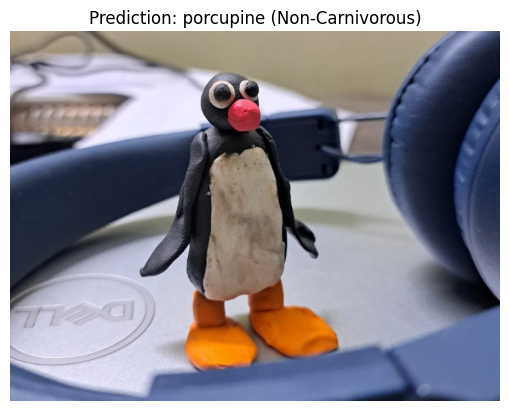

In [ ]:
predict_image("/content/drive/MyDrive/WhatsApp Image 2025-03-09 at 20.33.19_fbbc84f1.jpg")

In [ ]:
from collections import Counter

species_counts = Counter([label for _, label in train_dataset.samples])
for i, species in enumerate(species_classes):
    print(f"{species}: {species_counts[i]} images")

bear: 50 images
bison: 32 images
boar: 26 images
cow: 36 images
deer: 35 images
donkey: 36 images
elephant: 37 images
fox: 35 images
goat: 34 images
hippopotamus: 10 images
horse: 60 images
hyena: 28 images
leopard: 25 images
lion: 25 images
ox: 34 images
pig: 47 images
porcupine: 85 images
rhinoceros: 49 images
tiger: 60 images


In [ ]:
import os

train_path = "/content/drive/MyDrive/animals/train/tiger"
val_path = "/content/drive/MyDrive/animals/val/tiger"

print("Train images:", len(os.listdir(train_path)) if os.path.exists(train_path) else "Folder missing")
print("Val images:", len(os.listdir(val_path)) if os.path.exists(val_path) else "Folder missing")


Train images: 60
Val images: 16


In [ ]:
print("Classes detected:", train_dataset.classes)


Classes detected: ['bear', 'bison', 'boar', 'cow', 'deer', 'donkey', 'elephant', 'fox', 'goat', 'hippopotamus', 'horse', 'hyena', 'leopard', 'lion', 'ox', 'pig', 'porcupine', 'rhinoceros', 'tiger']


In [ ]:
from PIL import Image

image_dir = "/content/drive/MyDrive/animals/train/tiger"
for filename in os.listdir(image_dir):
    try:
        img = Image.open(os.path.join(image_dir, filename))
        img.verify()  # Check if file is a valid image
    except Exception as e:
        print(f"Corrupt image: {filename} - {e}")


In [ ]:
print("Total training samples:", len(train_dataset))
print("Samples per class:", {cls: sum(1 for x in train_dataset.samples if x[1] == idx) for idx, cls in enumerate(train_dataset.classes)})


Total training samples: 744
Samples per class: {'bear': 50, 'bison': 32, 'boar': 26, 'cow': 36, 'deer': 35, 'donkey': 36, 'elephant': 37, 'fox': 35, 'goat': 34, 'hippopotamus': 10, 'horse': 60, 'hyena': 28, 'leopard': 25, 'lion': 25, 'ox': 34, 'pig': 47, 'porcupine': 85, 'rhinoceros': 49, 'tiger': 60}


In [ ]:
for images, labels in train_loader:
    print("Batch labels:", labels.tolist())  # Check if tiger's class index appears
    break


Batch labels: [11, 15, 17, 12, 15, 11, 8, 10, 0, 11, 18, 12, 16, 11, 2, 9, 18, 2, 11, 7, 14, 7, 14, 12, 4, 10, 5, 7, 18, 18, 2, 6]


In [ ]:
# Get the class-to-index mapping
print(train_dataset.class_to_idx)


{'bear': 0, 'bison': 1, 'boar': 2, 'cow': 3, 'deer': 4, 'donkey': 5, 'elephant': 6, 'fox': 7, 'goat': 8, 'hippopotamus': 9, 'horse': 10, 'hyena': 11, 'leopard': 12, 'lion': 13, 'ox': 14, 'pig': 15, 'porcupine': 16, 'rhinoceros': 17, 'tiger': 18}


In [ ]:
tiger_index = train_dataset.class_to_idx["tiger"]

for images, labels in train_loader:
    print("Batch labels:", labels.tolist())  # Print class indices in a batch
    if tiger_index in labels.tolist():
        print("✅ Tiger images are being used in training!")
        break


Batch labels: [1, 14, 8, 14, 15, 12, 12, 1, 16, 18, 18, 1, 8, 16, 15, 10, 15, 9, 11, 9, 12, 15, 11, 6, 9, 16, 6, 14, 13, 17, 6, 17]
✅ Tiger images are being used in training!


In [ ]:
from collections import Counter

species_counts = Counter([label for _, label in train_dataset.samples])

for i, species in enumerate(species_classes):
    print(f"{species}: {species_counts[i]} images")


bear: 50 images
bison: 32 images
boar: 26 images
cow: 36 images
coyote: 35 images
deer: 36 images
donkey: 37 images
elephant: 35 images
fox: 34 images
goat: 10 images
hippopotamus: 60 images
horse: 28 images
hyena: 25 images
leopard: 25 images
lion: 34 images
ox: 47 images
pig: 85 images
porcupine: 49 images
rhinoceros: 60 images
tiger: 0 images


In [ ]:
print(train_dataset.class_to_idx)


{'bear': 0, 'bison': 1, 'boar': 2, 'cow': 3, 'deer': 4, 'donkey': 5, 'elephant': 6, 'fox': 7, 'goat': 8, 'hippopotamus': 9, 'horse': 10, 'hyena': 11, 'leopard': 12, 'lion': 13, 'ox': 14, 'pig': 15, 'porcupine': 16, 'rhinoceros': 17, 'tiger': 18}


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/animals/train/"))


['rhinoceros', 'tiger', 'porcupine', 'ox', 'leopard', 'hyena', 'lion', 'hippopotamus', 'horse', 'pig', 'goat', 'deer', 'fox', 'donkey', 'elephant', 'cow', 'bear', 'boar', 'bison']


In [ ]:
coyote_index = train_dataset.class_to_idx.get("coyote", -1)

if coyote_index == -1:
    print("❌ 'Coyote' class not found in dataset mapping!")

else:
    coyote_images = [img for img, label in train_dataset.samples if label == coyote_index]
    print(f"✅ Found {len(coyote_images)} images labeled as 'coyote'")


❌ 'Coyote' class not found in dataset mapping!


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np

# Set the model to evaluation mode
model.eval()

# Lists to store predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        species_output, carnivore_output = model(images)
        preds = torch.argmax(species_output, dim=1)  # Get predicted class

        all_preds.extend(preds.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store actual labels

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


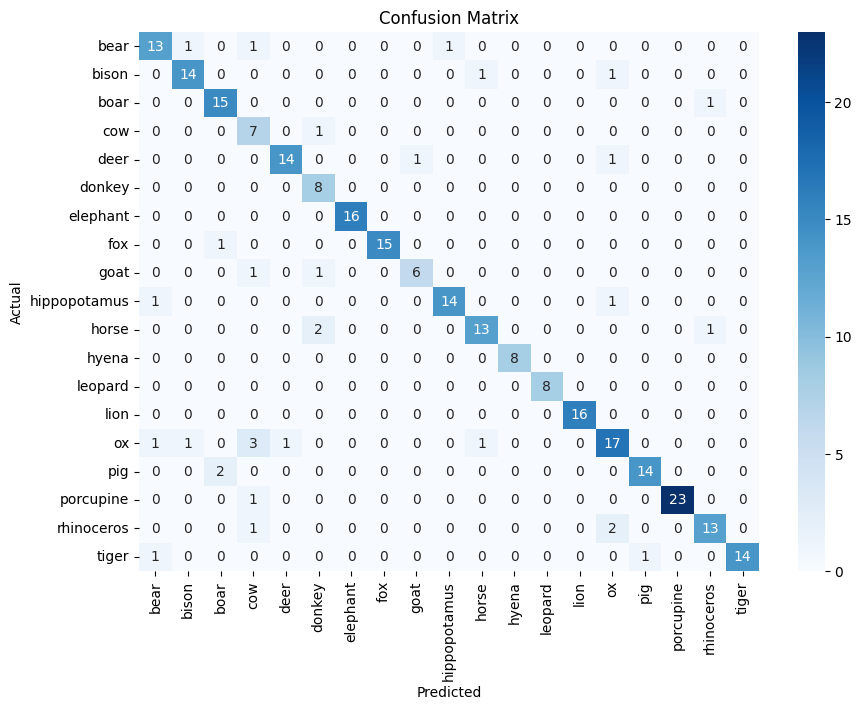

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

        bear       0.81      0.81      0.81        16
       bison       0.88      0.88      0.88        16
        boar       0.83      0.94      0.88        16
         cow       0.50      0.88      0.64         8
        deer       0.93      0.88      0.90        16
      donkey       0.67      1.00      0.80         8
    elephant       1.00      1.00      1.00        16
         fox       1.00      0.94      0.97        16
        goat       0.86      0.75      0.80         8
hippopotamus       0.93      0.88      0.90        16
       horse       0.87      0.81      0.84        16
       hyena       1.00      1.00      1.00         8
     leopard       1.00      1.00      1.00         8
        lion       1.00      1.00      1.00        16
          ox       0.77      0.71      0.74        24
         pig       0.93      0.88      0.90        16
   porcupine       1.00      0.96      0.98        24
  rh

In [ ]:
f1 = f1_score(all_labels, all_preds, average="weighted")
print(f"Weighted F1-score: {f1:.4f}")


Weighted F1-score: 0.8887
